1. Query GFS data, full extent and small part vitual file
2. Plot the virtual data
3. Create actual netCDF files
4. Store the files as netCDF

In [1]:
# for autocompletion disable the autocompletion tool 'jedi'
%config Completer.use_jedi = False


# formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

The coordinate system of the GFS Data is a little unusual, as longitudes run from 0 to 360 degrees. So a full extend would be latitudes -90° (south) to 90° (north) and longitudes 0° (west) to 360° (east).
Furthermore, there is a restriction in the way you can query data. Your west longitude coordinate needs to be smaller than the east coordinate. Accordingly, you cannot set a bounding box for a small area including the Meridian as then your west coordinate would be greater than the east coordinate.
Instead you may need to consider to query the full extend for the longitude.
We will have a look at this circumstance in this Jupyter Notebook.  

In this notebook we will use the NetCDF Subset Service (NCSS). For specifications have a look its rerefence: https://www.unidata.ucar.edu/software/tds/current/reference/NetcdfSubsetServiceReference.html


# Query full extend

In [2]:
from siphon.catalog import TDSCatalog

"""
    Siphon is a collection of Python utilities for downloading data from remote data services. 
    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. 
    It also provides clients to a variety of simple web services.
    Link to documentation:https://unidata.github.io/siphon/latest/index.html
"""

'\n    Siphon is a collection of Python utilities for downloading data from remote data services. \n    Much of Siphon’s current functionality focuses on access to data hosted on a THREDDS Data Server. \n    It also provides clients to a variety of simple web services.\n    Link to documentation:https://unidata.github.io/siphon/latest/index.html\n'

<IPython.core.display.Javascript object>

In [3]:
"""
    Read a catalog from THREDDS Data Server (TDS). THREDDS Catalogs are 
    logical directories of on-line data resources, encoded as XML documents, 
    which provide a place for annotations and other metadata about the data resources 
    to reside. This is how THREDDS-enabled data consumers find out what data is available 
    from data providers. 
    
    First construct a TDSCatalog instance pointing to the dataset of interest, in this 
    case TDS’ “Best” virtual dataset for the GFS global 0.25 degree collection of 
    GRIB files. 
    This catalog contains a single dataset.
"""
# Catalog https://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.html
best_gfs = TDSCatalog(
    catalog_url="http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/"
    "Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best"
)

# # https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/RR_CONUS_13km_20210131_0000.grib2/catalog.html
# best_gefs = TDSCatalog(
#     catalog_url="http://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/"
#     "CONUS_13km/catalog.xml?dataset=grib/NCEP/RAP/CONUS_13km"
# )

# Give out the name of the dataset
best_gfs.datasets

['Best GFS Quarter Degree Forecast Time Series']

<IPython.core.display.Javascript object>

In [4]:
# Inspect the metdata of the dataset
best_gfs.metadata

{'inherited': True,
 'serviceName': 'VirtualServices',
 'authority': ['edu.ucar.unidata'],
 'dataType': 'GRID',
 'dataFormat': 'GRIB-2',
 'documentation': {'summary': ['Forecasts grids starting from the 0 hour forecast every 3 hours out to 10 days, then 12 hour forecasts for days 10-16.',
   'NCEP GFS Model : AWIPS 230 (G) Grid. Global Lat/Lon grid. Model runs at 0, 6, 12, and 18Z. Horizontal= 721 by 14400 points, resolution 0.25 degree, Lat/Lon projection. Vertical= 1000 to 100 hPa mandatory pressure levels (26 levels); surface, height above ground, pressure layers.',
   'NCEP Global Forecast System Model, previously called AVN/MRF (Medium Range Forecast)'],
  'xlink': [{'title': 'COMET MetEd (Meteorology Education and Training) documentation',
    'href': 'http://meted.ucar.edu/nwp/pcu2/avintro.htm'},
   {'title': 'NCEP Model Notes',
    'href': 'http://www.nco.ncep.noaa.gov/pmb/products/gfs/'},
   {'title': 'NCEP Model documentation',
    'href': 'http://www.emc.ncep.noaa.gov/modeli

<IPython.core.display.Javascript object>

In [5]:
# Pull out the dataset and create list containing the dataset
best_ds = list(best_gfs.datasets.values())[0]

<IPython.core.display.Javascript object>

In [6]:
# Call subset() to prepare a request of a subset of the data
ncss = best_ds.subset()

<IPython.core.display.Javascript object>

In [7]:
# Look at the dataset object variables to see what data are available from the dataset
ncss.variables

{'5-Wave_Geopotential_Height_isobaric',
 'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_p

<IPython.core.display.Javascript object>

### Define query for full extend
Construct a query asking for data corresponding to a latitude and longitude box where 

- 90 lat is the northern extent 
- -90 lat is the southern extent 
- 0 long is the western extent 
- 360 is the eastern extent   

(Note: longitude values are the longitude distance from the prime meridian.)

Request the data for the current time.   

In [8]:
from datetime import datetime

<IPython.core.display.Javascript object>

In [9]:
# Use the ncss object to create a new query object, which facilitates asking
# for data from the server.
query = ncss.query()

<IPython.core.display.Javascript object>

### Define area

In [40]:
# Full extent
fe_West = 0
fe_East = 360
fe_South = -90
fe_North = 90

# Single grid=pixel
# sg_West = 20.49
# sg_East = 20.49 + 0.125
# sg_South = -49.24 - 0.125
# sg_North = -49.24

sg_West = -66.09016 + 360
sg_East = -66.09016 + 360 + 0.125
sg_South = 18.44777
sg_North = 18.44777 + 0.125

# sa_West = 14.8
# sa_East = 156.4
# sa_South = -55.6
# sa_North = 47

<IPython.core.display.Javascript object>

In [41]:
# Query a certain area
query.lonlat_box(west=sg_West, east=sg_East, south=sg_South, north=sg_North)


# Query a certain area and take the datetime closest to the actual datetime
# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.lonlat_box
# query.lonlat_box(south=fe_South,
#                  north=fe_North,
#                  west=fe_West,
#                  east=fe_East).time(
#     datetime.utcnow()
# )

var=Wind_speed_gust_surface&time=2021-03-06T00%3A00%3A00&west=293.90984000000003&east=294.03484000000003&south=18.44777&north=18.57277&accept=netcdf4

<IPython.core.display.Javascript object>

### Define the time or time range for the query
If you don't set a bounding box, the full extent will be queried

In [12]:
# Query a certain time range
# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.time_range
# query.time_range(start=datetime(2021, 2, 28), end=datetime(2021, 3, 6))

<IPython.core.display.Javascript object>

In [27]:
# Query a certain date
# https://unidata.github.io/siphon/latest/api/http_util.html#siphon.http_util.DataQuery.time
query.time(datetime(2021, 3, 6))

var=Wind_speed_gust_surface&time=2021-03-06T00%3A00%3A00&west=20.49&east=20.615&south=-49.365&north=-49.24&accept=netcdf4

<IPython.core.display.Javascript object>

In [14]:
# Set data format to be accepted, here netcdf4
query.accept("netcdf4")  # csv

time=2021-03-06T00%3A00%3A00&west=20.49&east=20.61&south=-49.36&north=-49.24&accept=netcdf4

<IPython.core.display.Javascript object>

In [15]:
# Set target variable
query.variables(
    "Wind_speed_gust_surface",
    #    "Geopotential_height_maximum_wind",
    #    "Temperature_maximum_wind",
)

var=Wind_speed_gust_surface&time=2021-03-06T00%3A00%3A00&west=20.49&east=20.61&south=-49.36&north=-49.24&accept=netcdf4

<IPython.core.display.Javascript object>

### Query the data

In [16]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

<IPython.core.display.Javascript object>

In [42]:
# Send request and open the received virtual data as xarray dataset
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
data

# Download the data as netCDF
lala = data.to_netcdf("52N_days_Wind1.nc")

<IPython.core.display.Javascript object>

In [43]:
# We want to inpect the variable Wind_speed_gust_surface
wind_3d = data.Wind_speed_gust_surface
wind_3d

<xarray.DataArray 'Wind_speed_gust_surface' (time: 1, lat: 1, lon: 1)>
array([[[6.105666]]], dtype=float32)
Coordinates:
    reftime  (time) datetime64[ns] ...
  * time     (time) datetime64[ns] 2021-03-06
  * lat      (lat) float32 18.5
  * lon      (lon) float32 294.0
Attributes:
    long_name:                      Wind speed (gust) @ Ground or water surface
    units:                          m/s
    abbreviation:                   GUST
    grid_mapping:                   LatLon_Projection
    Grib_Variable_Id:               VAR_0-2-22_L1
    Grib2_Parameter:                [ 0  2 22]
    Grib2_Parameter_Discipline:     Meteorological products
    Grib2_Parameter_Category:       Momentum
    Grib2_Parameter_Name:           Wind speed (gust)
    Grib2_Level_Type:               1
    Grib2_Level_Desc:               Ground or water surface
    Grib2_Generating_Process_Type:  Forecast

<IPython.core.display.Javascript object>

In [30]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename="time"):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError("No time variable found for " + var.name)


lat_1d = data["lat"]
lon_1d = data["lon"]

<IPython.core.display.Javascript object>

In [31]:
# Get forecasted date and time

# split in date and time
time_1d = find_time_var(wind_3d)
forecast_datetime_raw = time_1d[0].values
forecast_datetime_split = str(forecast_datetime_raw).split("T")

# date
forecast_date = forecast_datetime_split[0]

# time
forecast_time = forecast_datetime_split[1].split(":")[0]
forecast_time

'00'

<IPython.core.display.Javascript object>

In [21]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

<IPython.core.display.Javascript object>

In [32]:
# Reduce the dimensions of the data and get as an array with units
wind_2d = wind_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

<IPython.core.display.Javascript object>

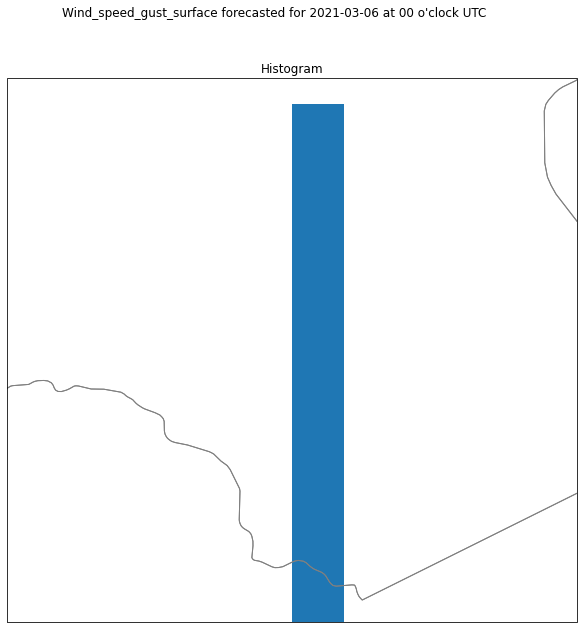

<IPython.core.display.Javascript object>

In [35]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    "{variable} forecasted for {date} at {time} o'clock UTC".format(
        variable=wind_3d.name, date=forecast_date, time=forecast_time
    )
)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, edgecolor="gray")
ax.coastlines()
p = wind_3d.isel(time=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")

In [ ]:
from IPython.display import Image

PATH = "/home/imke/Desktop/MariData/Data/GFS/images/"
image = Image(filename=PATH + "MediterraneanSea.png", width=800, height=800)
image

In [ ]:
from siphon.catalog import TDSCatalog

"""
    Read a catalog from THREDDS Data Server
    First we construct a TDSCatalog instance pointing to our dataset of interest, in this case TDS’ “Best” virtual
    dataset for the GFS global 0.25 degree collection of GRIB files. This will give us a good resolution 
    for our map. This catalog contains a single dataset.
"""
best_gfs = TDSCatalog(
    "http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/"
    "Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best"
)
best_gfs.datasets

In [ ]:
# We pull out this dataset and call subset() to set up requesting a subset of the data.
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

In [ ]:
query = ncss.query()

In [ ]:
ncss.variables

In [ ]:
# now we want to query a subset with a certain bounding box and variable
from datetime import datetime

query.lonlat_box(north=fe_North, south=fe_South, east=fe_East, west=fe_West).time(
    datetime.utcnow()
)
query.accept("netcdf4")
query.variables("Temperature_surface")

In [ ]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))
data

In [ ]:
temp_3d = data.Temperature_surface

In [ ]:
import pandas as pd

# Helper function for finding proper time variable
def find_time_var(var, time_basename="time"):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError("No time variable found for " + var.name)


lat_1d = data["lat"]
lon_1d = data["lon"]

In [ ]:
# Get forecasted date and time

# split in date and time
time_1d = find_time_var(temp_3d)
forecast_datetime_raw = time_1d[0].values
forecast_datetime_split = str(forecast_datetime_raw).split("T")

# date
forecast_date = forecast_datetime_split[0]

# time
forecast_time = forecast_datetime_split[1].split(":")[0]

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    "{variable} forecasted for {date} at {time} o'clock UTC".format(
        variable=temp_3d.name, date=forecast_date, time=forecast_time
    )
)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = temp_3d.isel(time1=0).plot(transform=ccrs.PlateCarree(), robust=True, cmap="Reds")

In [ ]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

# Reduce the dimensions of the data and get as an array with units
temp_2d = temp_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-100.03, -111.03, 35, 43])
ax.coastlines()
# Retrieve the state boundaries using cFeature and add to plot
# ax.add_feature(cfeature.STATES, edgecolor='gray')

# Contour temperature at each lat/long
contours = ax.contourf(
    lon_2d, lat_2d, temp_2d.to("degF"), 200, transform=ccrs.PlateCarree(), cmap="RdBu_r"
)
# Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f"Temperature forecast (\u00b0F) for {time_1d[0].values}Z", fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(
    lon_2d.flatten(),
    lat_2d.flatten(),
    linestyle="none",
    marker="o",
    color="black",
    markersize=0.1,
    alpha=0.1,
    transform=ccrs.PlateCarree(),
)